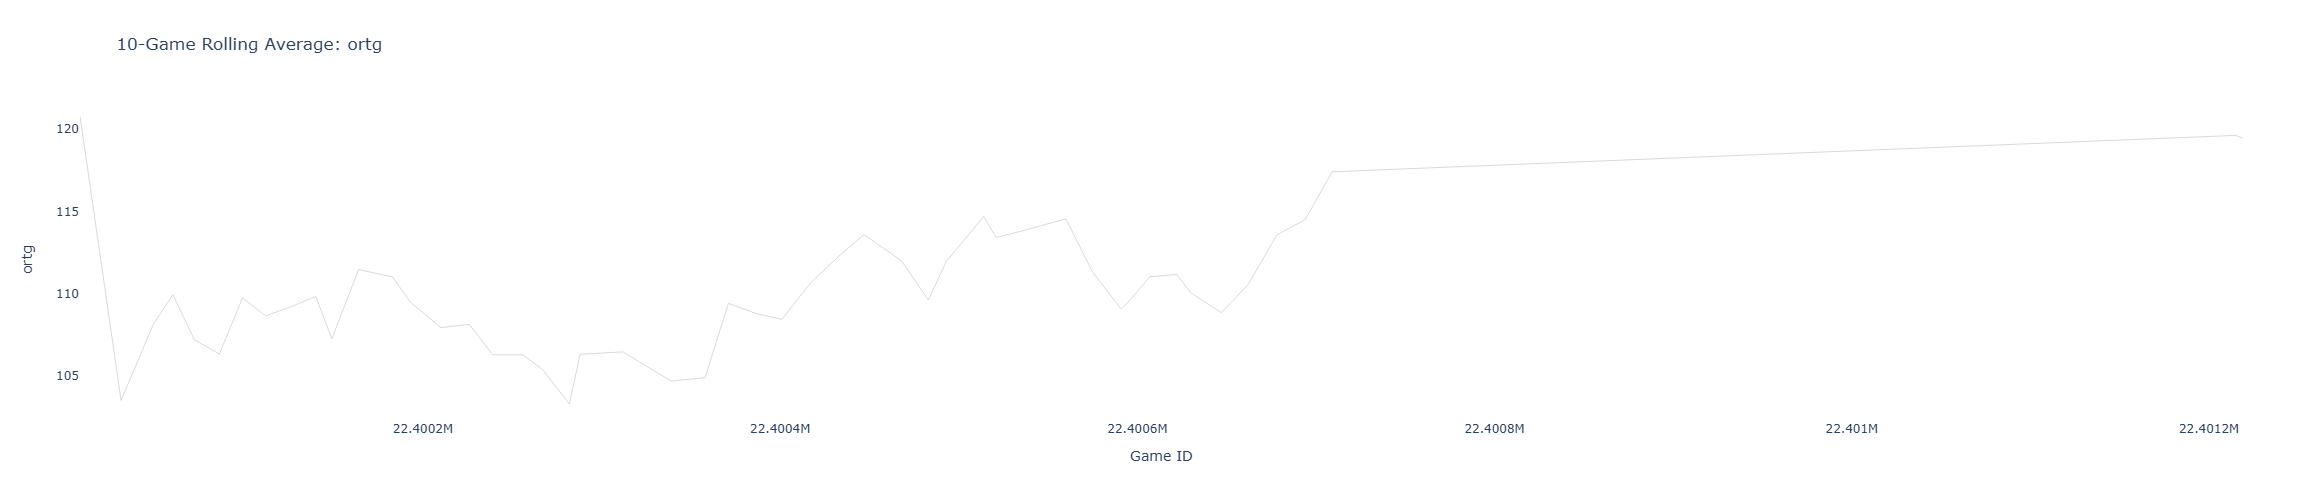

In [35]:
import requests
import pandas as pd
from datetime import datetime
import time
from typing import List, Dict
import logging

import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np

def get_team_abbreviations():
    """
    Returns a dictionary mapping team IDs to team abbreviations.
    """
    return {
        '1610612755': 'PHI', 
        '1610612744': 'GSW', 
        '1610612752': 'NYK', 
        '1610612737': 'ATL', 
        '1610612758': 'SAC', 
        '1610612738': 'BOS', 
        '1610612765': 'DET', 
        '1610612747': 'LAL', 
        '1610612741': 'CHI', 
        '1610612764': 'WAS', 
        '1610612745': 'HOU', 
        '1610612760': 'OKC', 
        '1610612749': 'MIL', 
        '1610612756': 'PHX', 
        '1610612757': 'POR', 
        '1610612739': 'CLE', 
        '1610612761': 'TOR', 
        '1610612762': 'UTA', 
        '1610612754': 'IND', 
        '1610612751': 'BRK', 
        '1610612743': 'DEN', 
        '1610612759': 'SAS', 
        '1610612746': 'LAC', 
        '1610612742': 'DAL', 
        '1610612766': 'CHO', 
        '1610612748': 'MIA', 
        '1610612753': 'ORL', 
        '1610612750': 'MIN', 
        '1610612763': 'MEM', 
        '1610612740': 'NOP'
    }

def plot_team_ratings(df: pd.DataFrame, n_games: int = 10) -> go.Figure:
    """
    Creates a scatter plot of offensive vs defensive ratings for all teams over their last n games.
    
    Args:
        df (pd.DataFrame): DataFrame containing team game logs with merged opponent data
        n_games (int): Number of most recent games to consider
    
    Returns:
        go.Figure: Plotly figure object containing the scatter plot
    """
    # Get team abbreviations
    team_dict = get_team_abbreviations()
    df = df.copy()
    df['TeamId'] = df['team_id'].astype(str)
    df['TeamName'] = df['TeamId'].map(team_dict)
    
    # Calculate team averages for last n games
    team_averages = (df.groupby('TeamId')
                    .tail(n_games)
                    .groupby('TeamId')
                    .agg({
                        'ortg': 'mean',
                        'opp_ortg': 'mean',
                        'TeamName': 'first'
                    })
                    .reset_index())
    
    # Create scatter plot
    fig = px.scatter(
        team_averages,
        x='ortg',
        y='opp_ortg',
        text='TeamName',
        title=f'Team Offensive vs Defensive Rating (Last {n_games} Games)',
        labels={
            'ortg': 'Offensive Rating',
            'opp_ortg': 'Opponent Offensive Rating (Defensive Rating)'
        }
    )
    
    # Add league averages as lines
    fig.add_hline(
        y=team_averages['opp_ortg'].mean(),
        line_dash='dash',
        line_color='gray',
        annotation_text='League Average'
    )
    fig.add_vline(
        x=team_averages['ortg'].mean(),
        line_dash='dash',
        line_color='gray',
        annotation_text='League Average'
    )
    
    # Update layout
    fig.update_traces(
        textposition='top center',
        marker=dict(size=12)
    )
    fig.update_layout(
        showlegend=False,
        plot_bgcolor='white',
        width=900,
        height=600
    )
    
    return fig

def plot_rolling_metric(
    df: pd.DataFrame,
    column: str,
    window: int = 10,
    highlight_team: str = None
) -> go.Figure:
    """
    Creates a line plot showing rolling averages of a selected metric for all teams,
    with optional highlighting for a specific team.
    
    Args:
        df (pd.DataFrame): DataFrame containing team game logs
        column (str): Column name to plot
        window (int): Rolling window size
        highlight_team (str, optional): TeamId to highlight
    
    Returns:
        go.Figure: Plotly figure object containing the line plot
    """
    # Get team abbreviations and prepare data
    team_dict = get_team_abbreviations()
    df = df.copy()
    df['TeamId'] = df['team_id'].astype(str)
    df['TeamName'] = df['TeamId'].map(team_dict)
    
    # Calculate rolling averages for each team
    teams_rolling = []
    
    for team in df['TeamId'].unique():
        team_data = df[df['TeamId'] == team].sort_values('GameId')
        rolling_avg = team_data[column].rolling(window=window, min_periods=1).mean()
        
        teams_rolling.append(pd.DataFrame({
            'GameId': team_data['GameId'],
            'TeamId': team_data['TeamId'],
            'TeamName': team_data['TeamName'],
            'Rolling_Average': rolling_avg
        }))
    
    rolling_df = pd.concat(teams_rolling)
    
    # Create base figure
    fig = go.Figure()
    
    # Add lines for each team
    for team in rolling_df['TeamId'].unique():
        team_data = rolling_df[rolling_df['TeamId'] == team]
        team_name = team_data['TeamName'].iloc[0]
        
        # Set line properties based on whether team is highlighted
        line_width = 3 if team == highlight_team else 1
        line_color = 'red' if team == highlight_team else 'gray'
        opacity = 1 if team == highlight_team else 0.3
        
        # Add trace with string name
        fig.add_trace(go.Scatter(
            x=team_data['GameId'],
            y=team_data['Rolling_Average'],
            name=str(team_name),  # Convert to string explicitly
            line=dict(width=line_width, color=line_color),
            opacity=opacity,
            showlegend=team == highlight_team
        ))
    
    # Update layout
    fig.update_layout(
        title=f'{window}-Game Rolling Average: {column}',
        xaxis_title='Game ID',
        yaxis_title=f'{column}',
        plot_bgcolor='white',
        width=900,
        height=500,
        showlegend=bool(highlight_team)
    )
    
    return fig
year=2025
df = team_trend(year)
fig = plot_rolling_metric(df,'ortg',10)

fig.show()
